In [ ]:
notebook_iteration = "i8"

In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-9a543798-748c-63e7-be58-d4352a7eb187)


## Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Set configs

In [ ]:
from pathlib import Path

#data_dir = Path("/content/drive/MyDrive/OTH/space-eye/dataset/flattened_cropped")
data_dir = Path("/content/drive/MyDrive/OTH/space-eye/dataset/jpg600")
models_dir = Path('/content/drive/MyDrive/OTH/space-eye/models') / notebook_iteration
logs_dir = Path('/content/drive/MyDrive/OTH/space-eye/logs') / notebook_iteration
img_height = 400
img_width = 400
batch_size = 32
num_splits = 5 # for k-fold crossvalidation

## Copy data to local runtime

In [ ]:
!mkdir /dataset
!cp -r $data_dir/* /dataset
data_dir = Path("/dataset")

mkdir: cannot create directory ‘/dataset’: File exists


In [ ]:
nonships_count = len(list(data_dir.glob('nonships/*')))
ships_count = len(list(data_dir.glob('ships/*')))

ships_count, nonships_count

(871, 880)

## Load Data

In [ ]:
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import pandas as pd
from pathlib import Path
import os

# load metadata
nonships_meta = pd.read_csv(Path("/content/drive/MyDrive/OTH/space-eye/dataset/nonshipsAIS_2017_Zone17.csv"), index_col=None)
ships_meta = pd.read_csv(Path("/content/drive/MyDrive/OTH/space-eye/dataset/shipsAIS_2017_Zone17.csv"), index_col=None)

# remove duplicate entries from csv data
nonships_meta = nonships_meta.drop_duplicates(subset="newindex")
ships_meta = ships_meta.drop_duplicates(subset="newindex")

# find image files
data = []
classifiers = os.listdir(data_dir)
for classifier in classifiers:
  classifier_dir = os.path.join(data_dir, classifier)
  for item in sorted(os.listdir(classifier_dir)):
    filename = os.path.join(classifier, item)
    number = Path(filename).stem.split("_")[-1]
    data.append([str(filename), str(classifier), int(number)])

image_data = pd.DataFrame(data, columns=['filename', 'class', 'number'])

#merge data
ships_meta["class"] = "ships"
ships_meta.rename(columns={"newindex" : "number"}, inplace=True)
nonships_meta["class"] = "nonships"
nonships_meta.rename(columns={"newindex" : "number"}, inplace=True)

df_data = image_data
df_data = pd.merge(df_data, ships_meta, how='left', on=["number", "class"])
df_data = pd.merge(df_data, nonships_meta, how='left', on=["number", "class"])

df_data

#set up dataset
full_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    seed=1337,
    image_size=(img_width, img_height),
    batch_size=batch_size,
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,filename,class,number,BaseDateTime_x,COG,CallSign,Cargo,Draft,Heading,IMO,LAT,LON,Length,MMSI,SOG,Status,VesselName,VesselType,Width,coordinate_x,datetime,envelope_x,BaseDateTime_y,coordinate_y,envelope_y
0,ships/ships_image_0.jpg,ships,0,2017-01-24T15:12:39,176.9,KCHV,80.0,12.2,179.0,IMO9353591,26.00165,-79.99460,183.2,366539000.0,5.7,under way using engine,OVERSEAS ANACORTES,1024.0,32.2,POINT (-79.99460000000001 26.00165),2017-01-24 15:12:39,"POLYGON ((-80.0146 25.98165, -79.9746000000000...",NaN,NaN,NaN
1,ships/ships_image_1.jpg,ships,1,2017-01-24T15:11:17,74.0,9HA3697,NaN,3.9,69.0,IMO9571143,25.75847,-80.10582,72.0,229894000.0,7.1,moored,AXIOMA,1019.0,11.8,POINT (-80.10581999999999 25.75847000000001),2017-01-24 15:11:17,POLYGON ((-80.12581999999999 25.73847000000001...,NaN,NaN,NaN
2,ships/ships_image_10.jpg,ships,10,2017-01-31T15:11:26,88.0,2ETL3,0.0,3.4,97.0,IMO1011501,26.09344,-80.06497,64.5,235088016.0,10.3,under way using engine,SEANNA,1019.0,12.1,POINT (-80.06497 26.09344),2017-01-31 15:11:26,"POLYGON ((-80.08497 26.07344, -80.044970000000...",NaN,NaN,NaN
3,ships/ships_image_100.jpg,ships,100,2017-04-05T15:14:10,-189.1,NaN,NaN,NaN,511.0,NaN,26.06031,-80.08372,12.8,368926067.0,4.3,NaN,46NS1501,NaN,NaN,POINT (-80.08372 26.06031),2017-04-05 15:14:10,"POLYGON ((-80.10372 26.04031, -80.06372 26.040...",NaN,NaN,NaN
4,ships/ships_image_101.jpg,ships,101,2017-04-05T15:13:14,-65.4,9V9313,70.0,10.5,164.0,IMO9589762,26.13761,-80.07653,180.0,566126000.0,0.1,at anchor,ORIENT TOKYO,1004.0,29.8,POINT (-80.07653000000001 26.13761),2017-04-05 15:13:14,"POLYGON ((-80.09653 26.11761, -80.056530000000...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1746,nonships/nonships_image_95.jpg,nonships,95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-03-20T15:13:57,POINT (-79.96891429114777 26.36658744768258),POLYGON ((-79.98891429114776 26.34658744768258...
1747,nonships/nonships_image_96.jpg,nonships,96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-03-20T15:12:16,POINT (-79.94215555981016 26.49006574369414),POLYGON ((-79.96215555981016 26.47006574369414...
1748,nonships/nonships_image_97.jpg,nonships,97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-03-29T22:18:06,POINT (-79.94756047140949 26.70008743099022),POLYGON ((-79.96756047140948 26.68008743099022...
1749,nonships/nonships_image_98.jpg,nonships,98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-03-29T22:18:00,POINT (-79.95636915029581 26.70351465628567),POLYGON ((-79.97636915029581 26.68351465628567...


### Display some loaded images

Found 1751 files belonging to 2 classes.


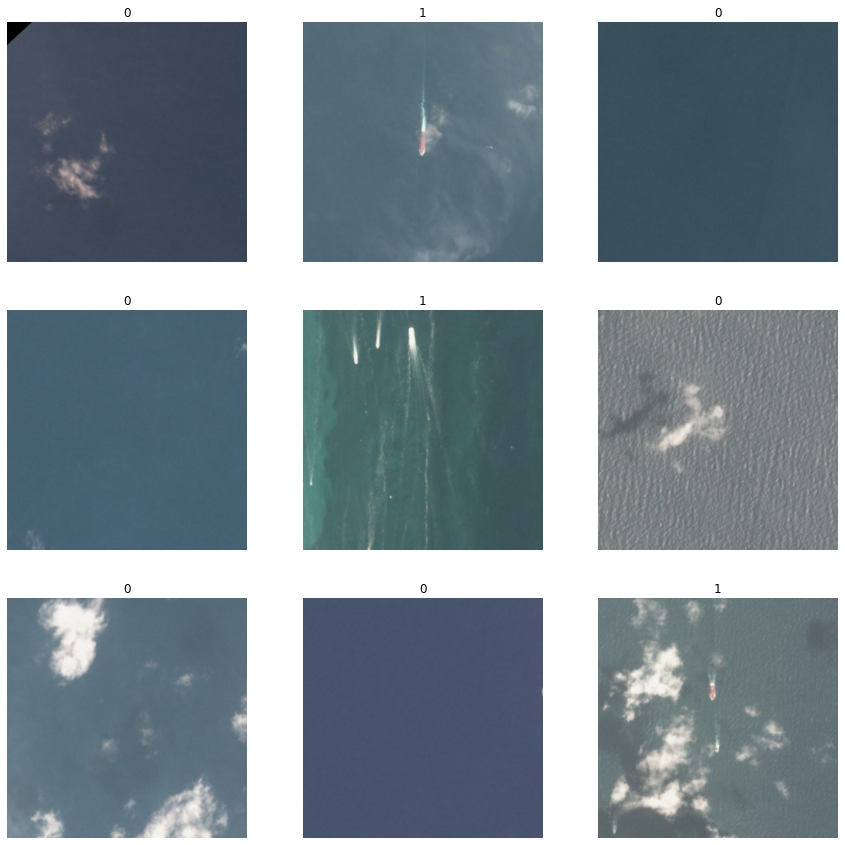

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

viz_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    seed=1337,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    label_mode='binary'
)

plt.figure(figsize=(15, 15))
for images, labels in viz_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


## Set up and visualize Data Augmentation

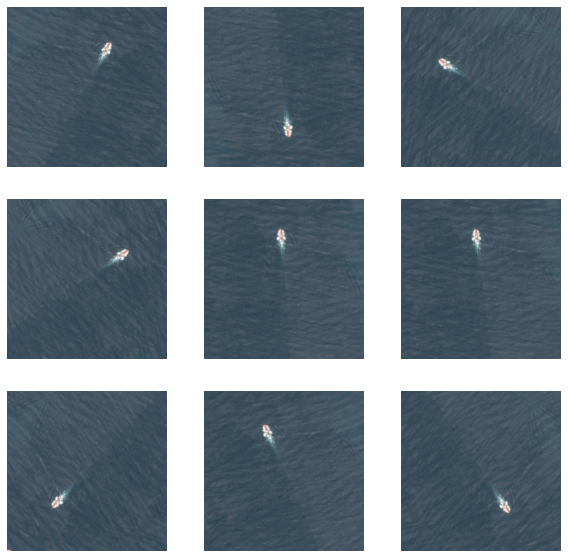

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in viz_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")



## Define Model

In [ ]:
from tensorflow import keras


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# def build_model():
#   base_model = keras.applications.InceptionResNetV2(
#       weights="imagenet",  # Load weights pre-trained on ImageNet.
#       input_shape=(img_width, img_height, 3),
#       include_top=False,
#   )  # Do not include the ImageNet classifier at the top.

#   # Freeze the base_model
#   base_model.trainable = False

#   # Create new model on top
#   inputs = keras.Input(shape=(img_width, img_height, 3))
#   x = inputs
#   #x = data_augmentation(inputs)  # Apply random data augmentation

#   # Pre-trained Xception weights requires that input be scaled
#   # from (0, 255) to a range of (-1., +1.), the rescaling layer
#   # outputs: `(inputs * scale) + offset`
#   #scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
#   #x = scale_layer(x)


#   # The base model contains batchnorm layers. We want to keep them in inference mode
#   # when we unfreeze the base model for fine-tuning, so we make sure that the
#   # base_model is running in inference mode here.
#   x = base_model(x, training=False)
#   x = keras.layers.GlobalAveragePooling2D()(x)
#   x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
#   outputs = keras.layers.Dense(1, activation='softmax')(x)
#   model = keras.Model(inputs, outputs)
#   model.summary()
  
#   return model

from tensorflow.keras import layers

def make_model(input_shape, num_classes):
  inputs = keras.Input(shape=input_shape)
  # Image augmentation block
  x = data_augmentation(inputs)
  x = inputs

  # Entry block
  x = layers.Rescaling(1.0 / 255)(x)
  x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.Conv2D(64, 3, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  previous_block_activation = x  # Set aside residual

  for size in [128, 256, 512, 728]:
      x = layers.Activation("relu")(x)
      x = layers.SeparableConv2D(size, 3, padding="same")(x)
      x = layers.BatchNormalization()(x)

      x = layers.Activation("relu")(x)
      x = layers.SeparableConv2D(size, 3, padding="same")(x)
      x = layers.BatchNormalization()(x)

      x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

      # Project residual
      residual = layers.Conv2D(size, 1, strides=2, padding="same")(
          previous_block_activation
      )
      x = layers.add([x, residual])  # Add back residual
      previous_block_activation = x  # Set aside next residual

  x = layers.SeparableConv2D(1024, 3, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.GlobalAveragePooling2D()(x)
  if num_classes == 2:
      activation = "sigmoid"
      units = 1
  else:
      activation = "softmax"
      units = num_classes

  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(units, activation=activation)(x)
  return keras.Model(inputs, outputs)

## Train

In [ ]:
# # displays tensorboard within the notebook
# %tensorboard --logdir logs_dir

In [ ]:
import keras.backend as K
import tensorflow as tf
from tensorflow.keras import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, roc_auc_score, auc, f1_score
import numpy as np

%load_ext tensorboard

#variables that hold our test results across runs
y_preds = []
y_tests = []
tprs = []
aucs = []
f1s = []
mean_fpr = np.linspace(0, 1, 100)

for fold in range(num_splits):
  print("FOLD " + str(fold))
  
  model_dir = models_dir / f"f{fold}"
  log_dir = logs_dir / f"f{fold}"

  #setup k-fold crossvalidations
  test_ds = full_ds.shard(num_splits, index=fold)
 
  fold_ds = full_ds.take(0)
  for i in range(num_splits):
    if i!=fold:
      fold_ds = fold_ds.concatenate(full_ds.shard(num_splits, index=i))
  
  fold_ds = fold_ds.shuffle(1000)
  
  num_in_fold = np.ceil((ships_count+nonships_count)*(1-1/num_splits)/batch_size)
  num_train = int(num_in_fold*0.8)
  num_val = num_in_fold - num_train
  
  train_ds = fold_ds.take(num_train)
  val_ds = fold_ds.skip(num_train).take(num_val)
  
  #improves performance
  AUTOTUNE = tf.data.AUTOTUNE
  train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
  
  # #Freeze the base model and only train the extra layer
  #model = build_model()
  model = make_model(input_shape=(img_width, img_height) + (3,), num_classes=2)
  
  model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=[metrics.BinaryAccuracy(), f1_m],
  )
  
  #checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold), 
	#						monitor='val_accuracy', verbose=1, 
	#						save_best_only=True, mode='max')
  tensorboard = keras.callbacks.TensorBoard(logs_dir)
  checkpoint = keras.callbacks.ModelCheckpoint(model_dir, save_best_only=True, monitor='val_loss')
  #early_stopping = keras.callbacks.EarlyStopping(patience=10)
  #callbacks = [tensorboard, checkpoint, early_stopping]
  callbacks = []

  #model.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=callbacks)
  model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=callbacks)

  # # Unfreeze the base_model and finetune whole model with low learning rate
  # model.trainable = True
  # model.summary()

  # model.compile(
  #     optimizer=keras.optimizers.Adam(1e-5),
  #     loss=keras.losses.BinaryCrossentropy(),
  #     metrics=[keras.metrics.BinaryAccuracy(), f1_m],
  # )

  # model.fit(train_gen, epochs=10, validation_data=validation_gen)

  # extract data from sharded test dataset again (this is a pain)
  # otherwise, using model.predict(test_ds) the labels were mismatched with the images for some reason
  x_test, y_test = [], []
  for images, labels in test_ds.unbatch():
    x_test.append(images.numpy())
    y_test.append(labels.numpy())
  x_test = np.array(x_test)
  y_test = np.array(y_test)

  # test predictions and calculate test metrics
  y_pred = model.predict(x_test).ravel().round().astype(int)
  y_preds.append(y_pred)
  y_tests.append(y_test)

  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  interp_tpr = np.interp(mean_fpr, fpr, tpr)
  interp_tpr[0] = 0.0
  tprs.append(interp_tpr)
  aucs.append(roc_auc_score(y_test, y_pred))
  f1s.append(f1_score(y_test, y_pred, average="binary"))

  print(y_pred)
  print(y_test)
  print(f1_score(y_test, y_pred, average="binary"))

  tf.keras.backend.clear_session()

Found 1751 files belonging to 2 classes.
FOLD 0
Epoch 1/50
35/35 [==============================] - 100s 2s/step - loss: 0.7465 - binary_accuracy: 0.6116 - f1_m: 0.5874 - val_loss: 0.6921 - val_binary_accuracy: 0.5243 - val_f1_m: 0.0000e+00
Epoch 2/50
35/35 [==============================] - 31s 886ms/step - loss: 0.5515 - binary_accuracy: 0.7375 - f1_m: 0.7253 - val_loss: 0.6993 - val_binary_accuracy: 0.5243 - val_f1_m: 0.0000e+00
Epoch 3/50
35/35 [==============================] - 31s 882ms/step - loss: 0.4656 - binary_accuracy: 0.8036 - f1_m: 0.7952 - val_loss: 0.7400 - val_binary_accuracy: 0.5243 - val_f1_m: 0.0000e+00
Epoch 4/50
35/35 [==============================] - 31s 878ms/step - loss: 0.4158 - binary_accuracy: 0.8170 - f1_m: 0.8078 - val_loss: 0.7870 - val_binary_accuracy: 0.5243 - val_f1_m: 0.0000e+00
Epoch 5/50
35/35 [==============================] - 31s 879ms/step - loss: 0.3682 - binary_accuracy: 0.8420 - f1_m: 0.8358 - val_loss: 1.0357 - val_binary_accuracy: 0.5243 - 

## Plot ROC 

In [ ]:
f1s

[0.8579881656804734,
 0.9244712990936556,
 0.9080118694362018,
 0.8894878706199462,
 0.8636363636363636]

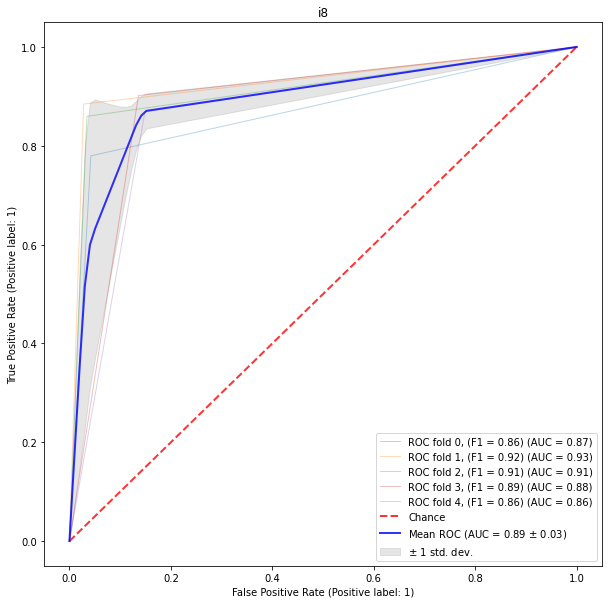

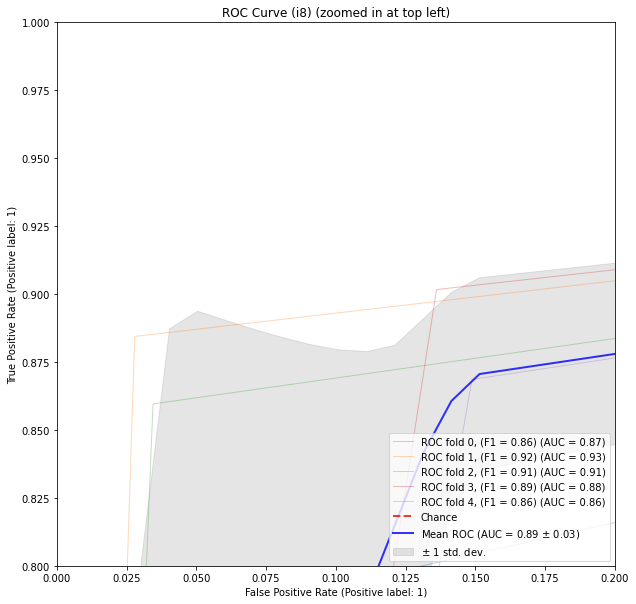

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(10,10))

for i in range(num_splits):
  viz = RocCurveDisplay.from_predictions(
        y_tests[i],
        y_preds[i],
        name="ROC fold {}, (F1 = {:.2f})".format(i, float(f1s[i])),
        alpha=0.3,
        lw=1,
        ax=ax)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=notebook_iteration,
)
ax.legend(loc="lower right")
plt.show()


fig, ax = plt.subplots(figsize=(10,10))
for i in range(num_splits):
  viz = RocCurveDisplay.from_predictions(
        y_tests[i],
        y_preds[i],
        name="ROC fold {}, (F1 = {:.2f})".format(i, float(f1s[i])),
        alpha=0.3,
        lw=1,
        ax=ax)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[0, 0.2],
    ylim=[0.8, 1],
    title= "ROC Curve (" +notebook_iteration + ")" + " (zoomed in at top left)",
)
ax.legend(loc="lower right")
plt.show()

